In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Flatten

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
2.8.0
[]


In [3]:
data = pd.read_csv('AUDCAD/AUD_CAD_rev.csv')


In [4]:
# GRYP event embedding
GRYP_IDX = {}
for idx, value in enumerate( list(data.event.unique())):
    GRYP_IDX[value] = idx

data['event'].replace(GRYP_IDX, inplace= True)


In [5]:
# string to index change -1 to 2
REPLACE_INDEX = {'buy':0, 'hold':1, 'sell':2, -1:2}
data.replace(REPLACE_INDEX, inplace= True)


In [7]:
# remove all nan
print(f'before: {data.shape}')
data.dropna(subset=['min_40', 'ratio top'],inplace=True)
data = data.reset_index(drop=True)
# train val test split 
Xtrain = data[(data['datetime']>='2018-06-25T09:00:00.000000000Z') & ((data['datetime']<='2021-09-13T00:45:00.000000000Z'))]
Xtrain.reset_index(drop=True, inplace=True)
Xvalid = data[(data['datetime']>='2021-09-13T01:00:00.000000000Z') & ((data['datetime']<='2022-02-04T07:45:00.000000000Z'))]
Xvalid.reset_index(drop=True, inplace=True)
Xtest = data[(data['datetime']>='2022-02-04T08:00:00.000000000Z') & ((data['datetime']<='2022-06-30T13:30:00.000000000Z'))]
Xtest.reset_index(drop=True, inplace=True)

print(f'after remove null values: {data.shape} \ntrain size: {Xtrain.shape}\nvalidtion size: {Xvalid.shape}\ntest size: {Xtest.shape}')


before: (440628, 172)
after remove null values: (440628, 172) 
train size: (80000, 172)
validtion size: (10000, 172)
test size: (10000, 172)


In [8]:
def generate_sequence(data, window_size):
    train_dt_ori, train_dt_scaled, target_minprice, target_maxprice, target_minp_scaled,\
    target_maxp_scaled, price_scaler_max, price_scaler_min = [], [], [], [], [], [], [], []

    train_dt_rsi15,train_dt_rsi25,train_dt_rsi35 = [], [], []
    train_dt_trend=[]
    train_dt_wr_atr=[]
    target_bhs = []

    seqlen = window_size # 更改window size对应label！

    scaler = MinMaxScaler()
    for index, row in data.iterrows(): 
        if index <= len(data)-seqlen:
            # OHLC numerical
            train_dt_ori.append(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].values)
            # Categorical
            train_dt_rsi15.append(data.loc[index:seqlen-1+index, ['rsi15']].values)
            train_dt_rsi25.append(data.loc[index:seqlen-1+index, ['rsi25']].values)
            train_dt_rsi35.append(data.loc[index:seqlen-1+index, ['rsi35']].values)
            train_dt_trend.append(data.loc[index:seqlen-1+index, ['Trend']].values)
            #numerical scale
            train_dt_wr_atr.append(scaler.fit_transform(data.loc[index:seqlen-1+index, ['wr15', 'wr25', 'wr35', 'atr15', 'atr25','atr35']].values))
            # min max scale within window size
            train_dt_scaled.append(scaler.fit_transform(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].values))
            
            # every window size/seq length predict min_10 label
            tmp_minprice = data.loc[seqlen-1+index, 'min_10'].tolist()
            target_minprice.append(tmp_minprice)
            # every window size/seq length predict max_10 label
            tmp_maxprice = data.loc[seqlen-1+index, 'max_10'].tolist()
            target_maxprice.append(tmp_maxprice)

            # bhs label
            target_bhs.append( data.loc[seqlen-1+index, ['ws10_pt10_sl8']].values)

            # max/min price according to ws seqlength
            max_v = max(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].max())
            min_v = min(data.loc[index:seqlen-1+index, ['open', 'high', 'low', 'close']].min())
            # min_10 max_10 label scaled 
            target_minp_scaled.append((tmp_minprice-min_v)/(max_v-min_v))
            target_maxp_scaled.append((tmp_maxprice-min_v)/(max_v-min_v))
            # save
            price_scaler_max.append(max_v)
            price_scaler_min.append(min_v)
            
    # change to np.array astype()
    train_arr_ohlc_scaled = np.array(train_dt_scaled).astype('float32')
    train_arr_rsi15 = np.array(train_dt_rsi15).astype('int64')
    train_arr_rsi25 = np.array(train_dt_rsi25).astype('int64')
    train_arr_rsi35 = np.array(train_dt_rsi35).astype('int64')
    train_arr_wr_atr = np.array(train_dt_wr_atr).astype('float32')
    target_minpArr_scaled = np.array(target_minp_scaled).astype('float32')
    target_maxpArr_scaled = np.array(target_maxp_scaled).astype('float32') 
    target_arr_bhs = np.array(target_bhs).astype('int64')
    train_arr_trend = np.array(train_dt_trend).astype('int64')
    
    # save features and labels in dict {'OHLC' : np.array([ohlc])}
    train_x_dict = {'OHLC':train_arr_ohlc_scaled,'rsi15': train_arr_rsi15,'rsi25': train_arr_rsi25,
                    'rsi35': train_arr_rsi35,'wr_atr':train_arr_wr_atr,'TREND': train_arr_trend,}

    train_y_dict = {'minp': target_minpArr_scaled, 'maxp': target_maxpArr_scaled, 'bhs':target_arr_bhs}
        
        
    return train_x_dict,train_y_dict, price_scaler_max,price_scaler_min,target_minprice, target_maxprice


In [9]:
# train set
train_x_dict,train_y_dict,price_scaler_max,price_scaler_min,train_minprice, train_maxprice = generate_sequence(Xtrain,10)
# validtion set
valid_x_dict,valid_y_dict,val_price_scaler_max,val_price_scaler_min,valid_minprice, valid_maxprice = generate_sequence(Xvalid,10)
# test set
test_x_dict,test_y_dict,test_price_scaler_max,test_price_scaler_min,test_minprice, test_maxprice = generate_sequence(Xtest,10)

## LSTM model 

In [10]:
def buildModel(seqlen, EMBED_DIM=4): 
    # feature input
    input_ohlc = layers.Input((seqlen,4), dtype=tf.float32, name='OHLC')
    input_rsi15 = layers.Input((seqlen,), dtype=tf.int64, name='rsi15')
    input_rsi25 = layers.Input((seqlen,), dtype=tf.int64, name='rsi25')
    input_rsi35 = layers.Input((seqlen,), dtype=tf.int64, name='rsi35')
    input_wr_atr = layers.Input((seqlen,6), dtype=tf.float32, name='wr_atr')
    
    input_TREND = layers.Input((seqlen,), dtype=tf.int64, name='TREND')
    
    # categorical embedding layer 
    emb_rsi15 = layers.Embedding(4, EMBED_DIM, name='rsi15_embedding')(input_rsi15)
    emb_rsi25 = layers.Embedding(4, EMBED_DIM, name='rsi25_embedding')(input_rsi25)
    emb_rsi35 = layers.Embedding(4, EMBED_DIM, name='rsi35_embedding')(input_rsi35)
    
    emb_TREND = layers.Embedding(3, EMBED_DIM, name='TREND_embedding')(input_TREND)

    # input feature to model
    features_rsi15 = layers.LSTM(128,dropout=0.2)(emb_rsi15)
    features_rsi25 = layers.LSTM(128,dropout=0.2)(emb_rsi25)
    features_rsi35 = layers.LSTM(128,dropout=0.2)(emb_rsi35)
    features_wr_atr = layers.LSTM(128,dropout=0.2)(input_wr_atr)
    features_TREND = layers.LSTM(128,dropout=0.2)(emb_TREND)
    features_ohlc = layers.LSTM(128, return_sequences=False)(input_ohlc)
    features_all = layers.concatenate([features_rsi15, features_rsi25, features_rsi35,features_wr_atr, features_ohlc])
    # dropout, layernormalization 
    
    output_maxp = layers.Dense(1, name='maxp')(features_all)
    output_minp = layers.Dense(1, name='minp')(features_all)
    # bhs label
    output_buyholdsell = layers.Dense(3, activation="softmax", name = 'bhs')(features_all)
    
    model = keras.Model(
                inputs=[input_ohlc, input_rsi15, input_rsi25, input_rsi35,input_wr_atr],
                outputs=[output_maxp, output_minp,output_buyholdsell],)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.00001, decay=0.001),
        loss={
            "maxp": 'mse',
            "minp":'mse',
            'bhs' : 'sparse_categorical_crossentropy',
        },
        metrics={
            "maxp": tf.keras.metrics.RootMeanSquaredError(),
            "minp": tf.keras.metrics.RootMeanSquaredError(),
            'bhs' :'acc',
        }
    )
    model.summary()
    
    return model 

In [11]:
LSTM_model = buildModel(10)

2022-11-22 17:18:40.591667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rsi15 (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 rsi25 (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 rsi35 (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 rsi15_embedding (Embedding)    (None, 10, 4)        16          ['rsi15[0][0]']                  
                                                                                              

In [12]:
# train_y_dic = train_y_dict.pop('bhs')
# Hyper parameter tuning 
# Test: {batch size : [32, 64 , 128, 256] epoch:[50,100,300,500...]}
history = LSTM_model.fit(train_x_dict, train_y_dict, epochs=50, 
    batch_size=256,verbose = 1, validation_data=(valid_x_dict, valid_y_dict), shuffle = False)

Epoch 1/50
313/313 [==============================] - 63s 173ms/step - loss: 2.7775 - maxp_loss: 1.2462 - minp_loss: 0.4397 - bhs_loss: 1.0916 - maxp_root_mean_squared_error: 1.1163 - minp_root_mean_squared_error: 0.6631 - bhs_acc: 0.3956 - val_loss: 2.2458 - val_maxp_loss: 0.7965 - val_minp_loss: 0.3537 - val_bhs_loss: 1.0956 - val_maxp_root_mean_squared_error: 0.8925 - val_minp_root_mean_squared_error: 0.5948 - val_bhs_acc: 0.3752
Epoch 2/50
313/313 [==============================] - 51s 162ms/step - loss: 2.1785 - maxp_loss: 0.6551 - minp_loss: 0.4318 - bhs_loss: 1.0916 - maxp_root_mean_squared_error: 0.8094 - minp_root_mean_squared_error: 0.6571 - bhs_acc: 0.3980 - val_loss: 1.8404 - val_maxp_loss: 0.4006 - val_minp_loss: 0.3446 - val_bhs_loss: 1.0952 - val_maxp_root_mean_squared_error: 0.6329 - val_minp_root_mean_squared_error: 0.5870 - val_bhs_acc: 0.3750
Epoch 3/50
313/313 [==============================] - 46s 147ms/step - loss: 1.9287 - maxp_loss: 0.4130 - minp_loss: 0.4245 - 

Epoch 20/50
313/313 [==============================] - 45s 143ms/step - loss: 1.8203 - maxp_loss: 0.3387 - minp_loss: 0.3930 - bhs_loss: 1.0886 - maxp_root_mean_squared_error: 0.5819 - minp_root_mean_squared_error: 0.6269 - bhs_acc: 0.3983 - val_loss: 1.6817 - val_maxp_loss: 0.2763 - val_minp_loss: 0.3094 - val_bhs_loss: 1.0961 - val_maxp_root_mean_squared_error: 0.5256 - val_minp_root_mean_squared_error: 0.5563 - val_bhs_acc: 0.3750
Epoch 21/50
313/313 [==============================] - 41s 131ms/step - loss: 1.8185 - maxp_loss: 0.3377 - minp_loss: 0.3923 - bhs_loss: 1.0885 - maxp_root_mean_squared_error: 0.5811 - minp_root_mean_squared_error: 0.6263 - bhs_acc: 0.3983 - val_loss: 1.6799 - val_maxp_loss: 0.2752 - val_minp_loss: 0.3086 - val_bhs_loss: 1.0961 - val_maxp_root_mean_squared_error: 0.5246 - val_minp_root_mean_squared_error: 0.5555 - val_bhs_acc: 0.3750
Epoch 22/50
313/313 [==============================] - 42s 133ms/step - loss: 1.8167 - maxp_loss: 0.3368 - minp_loss: 0.3914

Epoch 39/50
313/313 [==============================] - 46s 147ms/step - loss: 1.7948 - maxp_loss: 0.3249 - minp_loss: 0.3817 - bhs_loss: 1.0882 - maxp_root_mean_squared_error: 0.5700 - minp_root_mean_squared_error: 0.6178 - bhs_acc: 0.3983 - val_loss: 1.6581 - val_maxp_loss: 0.2637 - val_minp_loss: 0.2985 - val_bhs_loss: 1.0959 - val_maxp_root_mean_squared_error: 0.5135 - val_minp_root_mean_squared_error: 0.5463 - val_bhs_acc: 0.3750
Epoch 40/50
313/313 [==============================] - 47s 149ms/step - loss: 1.7943 - maxp_loss: 0.3247 - minp_loss: 0.3814 - bhs_loss: 1.0882 - maxp_root_mean_squared_error: 0.5698 - minp_root_mean_squared_error: 0.6176 - bhs_acc: 0.3983 - val_loss: 1.6573 - val_maxp_loss: 0.2633 - val_minp_loss: 0.2981 - val_bhs_loss: 1.0959 - val_maxp_root_mean_squared_error: 0.5131 - val_minp_root_mean_squared_error: 0.5460 - val_bhs_acc: 0.3750
Epoch 41/50
313/313 [==============================] - 42s 134ms/step - loss: 1.7934 - maxp_loss: 0.3243 - minp_loss: 0.3809

In [ ]:
# save model
LSTM_model.save('AUDCAD/baseline.h5')

# Evaluation

In [13]:
# accuary calculation
def evaluate_regression_prediction(y_pred, y_true, model_name, printFlag=True):

    errors = np.array(y_pred) - np.array(y_true)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(100*errors/y_true).mean()
    if printFlag:
        print(model_name + ':')
        print('Mean Absolute Error: {:.8f}'.format(mae))
        print('Mean Absolute Percentage Error: {:.8f}'.format(mape))
        print('Mean Square Error: {:.8f}'.format(mse))
        print('Root Mean Square Error: {:.8f}'.format(rmse))
        print('')

    return mae, mape, mse, rmse

def inverse_buyholdsell_label(output_ls):
    # softmax vector find max one
    temp = [0,0,0]
    idx = 0   
    for i in output_ls:
        if i == max(output_ls):
            temp[idx] = 1
        idx+=1
    return temp

# Predict test
def visualize_result(model, train_x_dict, train_y_dict,price_scaler_min, price_scaler_max,train_minprice,train_maxprice):
    y_pred = model.predict(train_x_dict)
    print('-' * 100)
    print('MinMax Price Prediction Result: ')

    # max
    y_pred[0]
    # min
    y_pred[1]
    # buy hold sell label
    # y_pred[2]

    # Inverse prediction to orginal scale
    min_output,max_output = [],[]
    for i in range(len(y_pred[0])):
        #print(price_scaler_max[i] - price_scaler_min[i], y_pred[0][i] , price_scaler_min[i] )
        max_output.append( (y_pred[0][i] * (price_scaler_max[i] - price_scaler_min[i])) + price_scaler_min[i] )
        min_output.append( (y_pred[1][i] * (price_scaler_max[i] - price_scaler_min[i])) + price_scaler_min[i] )

    a,b,c,d =evaluate_regression_prediction(max_output,train_maxprice,'Model')
    a,b,c,d =evaluate_regression_prediction(min_output,train_minprice,'Model')


    # Prediction result on Test set
    plt.figure(2)
    plt.figure(figsize=(15,6))
    plt.plot(max_output, label='Max Predict')
    #plt.plot(min_output, label='Min Predict')
    #plt.plot(train_minprice, label='Actual Min Price') 
    plt.plot(train_maxprice, label='Actual Max Price') 
    plt.title('Predict Max & Actual Max')
    plt.legend(loc = 'upper right')
    
    plt.figure(2)
    plt.figure(figsize=(15,6))
    plt.plot(min_output, label='Min Predict')
    plt.plot(train_minprice, label='Actual Min Price') 
    plt.title('Predict Min & Actual Min')
    plt.legend(loc = 'upper right')

    # Inverse buy hold sell prediction label
    if len(y_pred) >2:
        res = []
        for i in y_pred[2]:
            pre = inverse_buyholdsell_label(list(i))
            res.append(pre)
        

        # res
        ground_true = train_y_dict['bhs']
        ground_true_matrix = to_categorical(ground_true)
        # print(f'Accuracy for predicting buy hold sell label: {accuracy_score(res, valid_y_dict['bhs']):.4f}')
        # accuracy_score(res, ground_true_matrix)

        print(f'Accuracy for predicting buy hold sell label: {accuracy_score(ground_true_matrix,res):.4f}')
        print(classification_report(ground_true_matrix,res))
        print('-' * 100)
        
def visualize_history(history):
    # visual_loss = ['maxp_loss', 'minp_loss', 'bhs_loss','val_maxp_loss', 'val_minp_loss', 'val_bhs_loss']
    visual_loss = ['maxp_loss', 'minp_loss','val_maxp_loss', 'val_minp_loss']
    visual_acc = ['Train Accuracy', 'Validation Accuracy']

    plt.figure(2)
    plt.figure(figsize=(15,6))
    for i in visual_loss:
        history.history[i]
        plt.plot(history.epoch,history.history[i], label =i )
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper right')

    plt.figure(2)
    history.history[i]
    plt.bar(x = visual_acc, height = [history.history['bhs_acc'][-1],history.history['val_bhs_acc'][-1]] )
    plt.xlabel('Accuracy')
    plt.ylabel('Train & Validation')
    plt.title('Label BuyHoldSell Prediction Accuracy')
    plt.show()

----------------------------------------------------------------------------------------------------
MinMax Price Prediction Result: 
Model:
Mean Absolute Error: 0.01782063
Mean Absolute Percentage Error: 1.93981720
Mean Square Error: 0.00048565
Root Mean Square Error: 0.02203738

Model:
Mean Absolute Error: 0.01788550
Mean Absolute Percentage Error: 1.95152185
Mean Square Error: 0.00048920
Root Mean Square Error: 0.02211797

Accuracy for predicting buy hold sell label: 0.2908
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3768
           1       0.29      1.00      0.45      2905
           2       0.00      0.00      0.00      3318

   micro avg       0.29      0.29      0.29      9991
   macro avg       0.10      0.33      0.15      9991
weighted avg       0.08      0.29      0.13      9991
 samples avg       0.29      0.29      0.29      9991

-----------------------------------------------------------------------------------

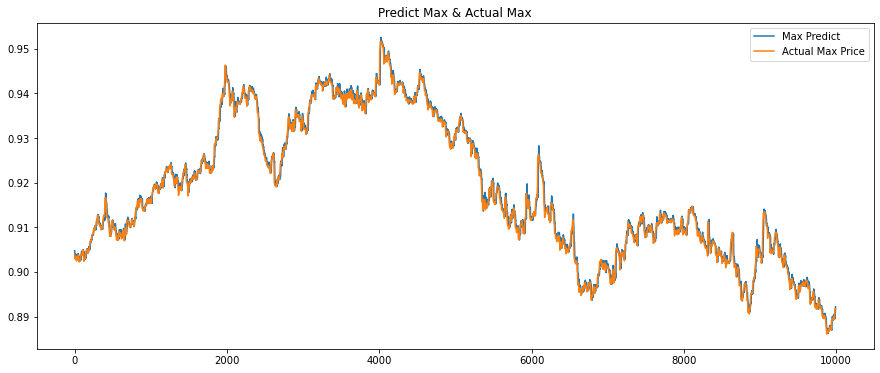

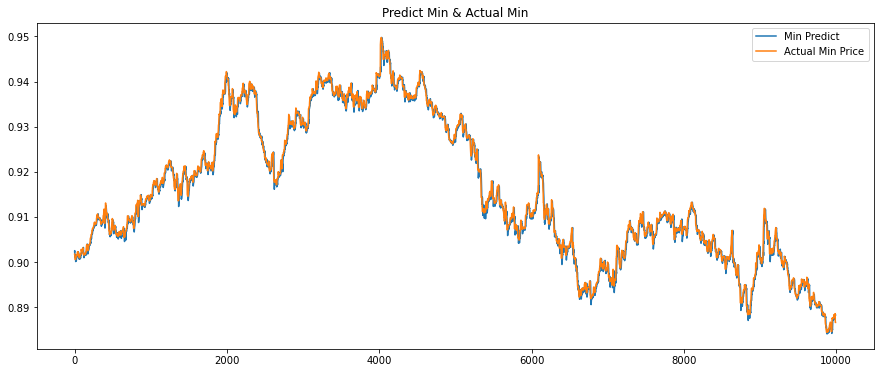

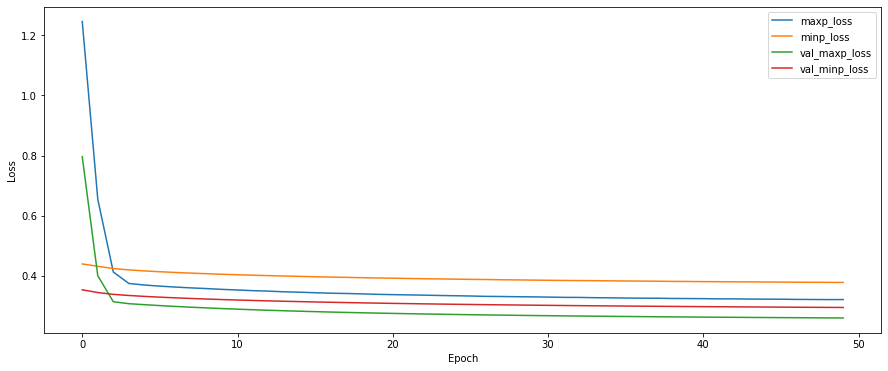

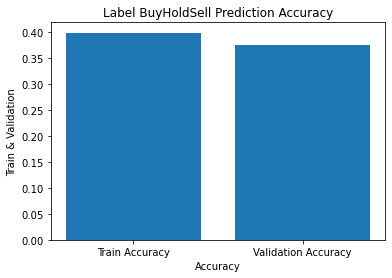

In [14]:
visualize_result(LSTM_model,test_x_dict, test_y_dict, test_price_scaler_min, test_price_scaler_max,test_minprice,test_maxprice)
# visualize_result(transformer,test_x_dict, test_price_scaler_min,test_price_scaler_max,test_minprice, test_maxprice)
visualize_history(history)